In [25]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

!pip -q install torchmetrics
from torchmetrics import Accuracy

device="cuda" if torch.cuda.is_available() else "cpu"

import tqdm as tqdm

**Data:**

In [3]:
train_data=datasets.FashionMNIST( root="/content/Dataset",
                                 train=True,
                                 download=True,
                                 transform=ToTensor(),
                                 target_transform=None)

test_data=datasets.FashionMNIST( root="/content/Dataset",
                                train=False,
                                download=True,
                                transform=ToTensor(),
                                target_transform=None)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/Dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/Dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/Dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/Dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/Dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/Dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/Dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/Dataset/FashionMNIST/raw



In [7]:
img, label=train_data[0]

img.shape, label

(torch.Size([1, 28, 28]), 9)

In [9]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
len(train_data.data), len(test_data.data)

(60000, 10000)

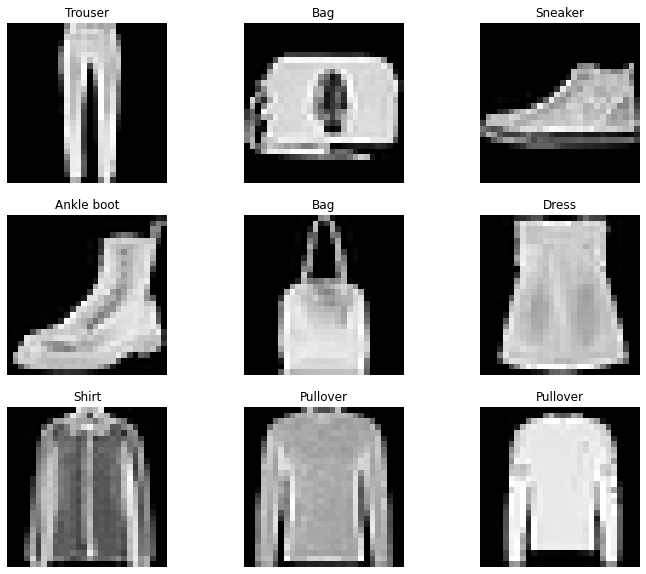

In [10]:
fig=plt.figure(figsize=(12,10))
rows, cols=3,3
for i in range(1, rows * cols + 1):

    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False);

**DataLoader:**

In [12]:
from torch.utils.data import DataLoader

#creating mini batches, gd will be comp for multiple times in an epoch for every mini batch
batchsize=32

train_dataloader=DataLoader(train_data, batch_size=batchsize, shuffle=True)

test_dataloader=DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [13]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

**Model - TinyVGG:**

input -> [conv -> ReLU -> conv -> ReLU -> MaxPool]^2 -> FFC -> output

In [55]:
class cnnmodel(nn.Module):

  def __init__(self, input, output, hidden_units):

    super().__init__()

    self.stack1=nn.Sequential(
        
        nn.Conv2d(in_channels=input, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.stack2=nn.Sequential(
        
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output)
    )

  def forward(self, x: torch.Tensor):

    return self.classifier(self.stack2(self.stack1(x)))
  

In [56]:
torch.manual_seed(42)
model1=cnnmodel(input=1, output=len(train_data.classes), hidden_units=10).to(device)
model1

cnnmodel(
  (stack1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stack2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

**loss function and optimizer:**

In [57]:
CELloss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model1.parameters(), lr=0.1)

**Training and Testing Loop:**

In [58]:
def traintest(model, epochs, train_dataloader, test_dataloader):
  epochs=epochs
  epoch_count=[]
  train_loss_val=[]
  test_loss_val=[]

  accuracy=Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)

  for epoch in range(epochs):
    print(f"EPOCH:{epoch} ---------------------------------------------------------")
    epoch_count.append(epoch)

    #TRAIN:
    model.train()
    train_loss, train_acc=0,0

    for batch,(x_train,y_train) in enumerate(train_dataloader):
      x_train,y_train=x_train.to(device), y_train.to(device)

      ypred_train=model(x_train)
      trainloss=CELloss(ypred_train, y_train)
      train_loss+=trainloss
      train_acc+=accuracy(ypred_train.argmax(dim=1), y_train)

      optimizer.zero_grad()
      trainloss.backward()
      optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    train_loss_val.append(train_loss.detach().numpy())
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")


    #TEST:
    model1.eval()
    with torch.inference_mode():
      test_loss,test_acc=0,0

      for x_test,y_test in test_dataloader:
        x_test, y_test=x_test.to(device), y_test.to(device)
        ypred_test=model1(x_test)
        testloss=CELloss(ypred_test, y_test)

        test_loss += testloss
        test_acc +=accuracy(ypred_test.argmax(dim=1), y_test)

      test_loss /= len(test_dataloader)
      test_acc /= len(test_dataloader)

      test_loss_val.append(test_loss.detach().numpy())
      print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%")

  return epoch_count,train_loss_val, test_loss_val  


epoch_count, train_loss_val, test_loss_val=traintest(model1, 6, train_dataloader, test_dataloader)

EPOCH:0 ---------------------------------------------------------
Train loss: 0.57716 | Train accuracy: 79.14%
Test loss: 0.39148 | Test accuracy: 85.90%
EPOCH:1 ---------------------------------------------------------
Train loss: 0.35641 | Train accuracy: 87.21%
Test loss: 0.37143 | Test accuracy: 86.04%
EPOCH:2 ---------------------------------------------------------
Train loss: 0.31685 | Train accuracy: 88.59%
Test loss: 0.33307 | Test accuracy: 87.75%
EPOCH:3 ---------------------------------------------------------
Train loss: 0.29470 | Train accuracy: 89.33%
Test loss: 0.31484 | Test accuracy: 88.52%
EPOCH:4 ---------------------------------------------------------
Train loss: 0.28236 | Train accuracy: 89.80%
Test loss: 0.29692 | Test accuracy: 89.18%
EPOCH:5 ---------------------------------------------------------
Train loss: 0.27105 | Train accuracy: 90.18%
Test loss: 0.29386 | Test accuracy: 89.19%


In [61]:
torch.manual_seed(42)
model1=cnnmodel(input=1, output=len(train_data.classes), hidden_units=15).to(device)
model1

CELloss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model1.parameters(), lr=0.1)

epoch_count, train_loss_val, test_loss_val=traintest(model1, 7, train_dataloader, test_dataloader)

EPOCH:0 ---------------------------------------------------------
Train loss: 0.59384 | Train accuracy: 78.19%
Test loss: 0.45113 | Test accuracy: 82.74%
EPOCH:1 ---------------------------------------------------------
Train loss: 0.34914 | Train accuracy: 87.41%
Test loss: 0.33522 | Test accuracy: 87.98%
EPOCH:2 ---------------------------------------------------------
Train loss: 0.30688 | Train accuracy: 89.00%
Test loss: 0.30152 | Test accuracy: 88.82%
EPOCH:3 ---------------------------------------------------------
Train loss: 0.28528 | Train accuracy: 89.92%
Test loss: 0.38688 | Test accuracy: 86.56%
EPOCH:4 ---------------------------------------------------------
Train loss: 0.26803 | Train accuracy: 90.43%
Test loss: 0.28782 | Test accuracy: 89.69%
EPOCH:5 ---------------------------------------------------------
Train loss: 0.25877 | Train accuracy: 90.79%
Test loss: 0.28494 | Test accuracy: 89.73%
EPOCH:6 ---------------------------------------------------------
Train loss

**Plot Loss:**

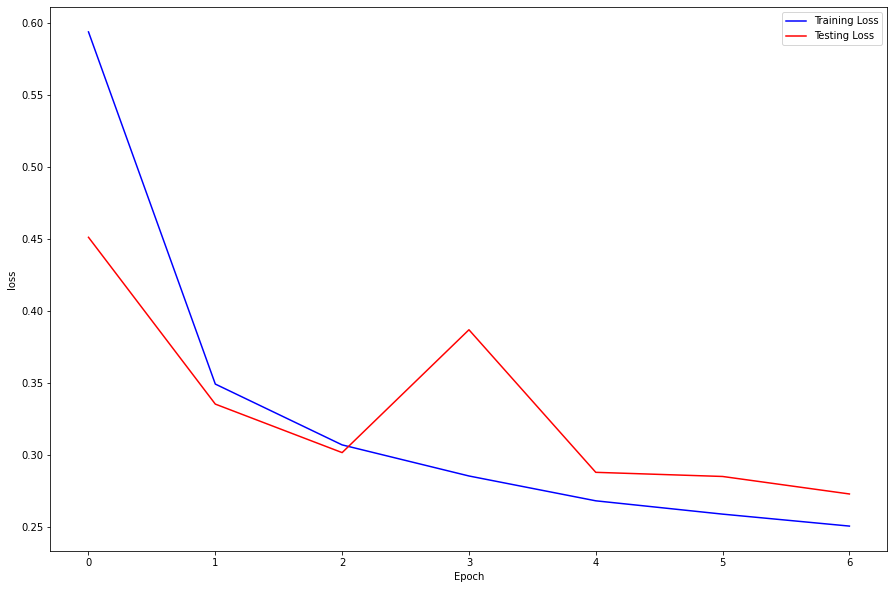

In [62]:
plt.figure(figsize=(15,10))
plt.plot(epoch_count, train_loss_val, c="b", label="Training Loss")
plt.plot(epoch_count, test_loss_val, c="r", label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()